# **1. Basics**
**Prerequisites**

`pytorch`, `torchvision`, `numpy`, `openCV2`,`matplotlib`

In [1]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For utilities
import time, sys, os
sys.path.insert(0, '../../')

# For conversion
import cv2
import opencv_transforms.transforms as TF
import dataloader

# For everything
import torch
import torch.nn as nn
import torchvision.utils as vutils

# For our model
import mymodels
import torchvision.models

# To ignore warning
import warnings
warnings.simplefilter("ignore", UserWarning)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device=='cuda':
    print("The gpu to be used : {}".format(torch.cuda.get_device_name(0)))
else:
    print("No gpu detected")

The gpu to be used : GeForce GTX 1060 6GB


# **2. Loading dataset**

## 2.2 Load data

To pre-process input images, the module `opencv_transforms.transforms` and `opencv_transforms.functional` are used. These are implemented with **openCV** so much faster than `torchvision.transforms` which is based on **Pillow**.[2] You can download the module on [2].

To download validation dataset, go [1] and download. Unzip the images on directory `./dataset/val/`.

I've alreay set some validation and test images. If you want test on orther images, put the image on `./dataset/test/`. 

[2] Jim Bohnslav,"opencv_transforms", https://github.com/jbohnslav/opencv_transforms, 2020.1.13.

In [2]:
# batch_size. number of cluster
batch_size = 1

# Validation 
print('Loading Validation data...', end=' ')
val_transforms = TF.Compose([
    TF.Resize(256),
    ])

refer_transforms = TF.Compose([
    #TF.RandomResizedCrop(256, (0.1, 1.2)),
    #TF.RandomRotation(10),
    #TF.RandomHorizontalFlip(),
    ])

val_imagefolder = dataloader.PairImageFolder('../../dataset/yosemite',
                                              val_transforms,
                                              mode='test')
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=batch_size, shuffle=True)
print("Done!")
print("Validation data size : {}".format(len(val_imagefolder)))

Loading Validation data... Done!
Validation data size : 238


## 2.3 Dataset Test

Check the dataset

In [4]:
temp_batch_iter = iter(val_loader)

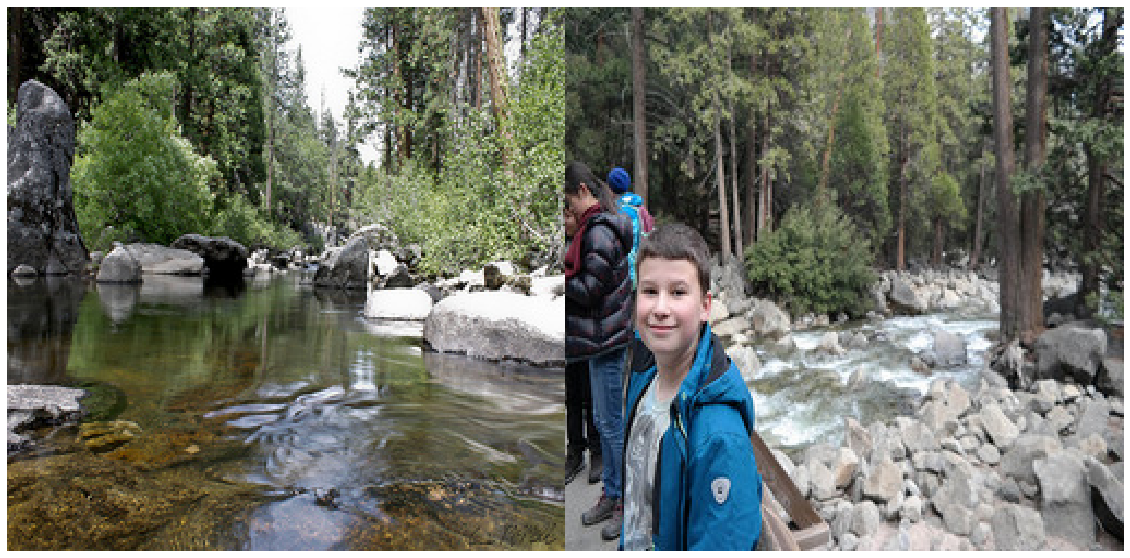

In [7]:
temp_batch = next(temp_batch_iter)
imgA = temp_batch[0]
imgB = temp_batch[1]

dataloader.show_example([imgA, imgB], (20,10))

# **3. Load the Model**

The model are implemented on `mymodels.py`.

To load the model weights, download the checkpoint on https://drive.google.com/open?id=1pIZCjubtyOUr7AXtGQMvzcbKczJ9CtQG (449MB) and unzip on directory `./checkpoint`. 
Then the file on `./checkpoint/edge2color/ckpt.pth` will be loaded.


In [3]:
# A : Edge, B : Color
num_att=5
netG_A2B = mymodels.Generator(input_nc=3, 
                              output_nc=3, 
                              num_att=num_att, 
                              ngf=64, 
                              n_middle=9, 
                              norm='IN', 
                              activation='relu',
                              pretrained=False).to(device)
netG_B2A = mymodels.Generator(input_nc=3, 
                              output_nc=3, 
                              num_att=num_att, 
                              ngf=64, 
                              n_middle=9, 
                              norm='IN', 
                              activation='relu',
                              pretrained=False).to(device)

torch.backends.cudnn.benchmark = True

In [4]:
def load(netG_A2B, netG_B2A):
    print('Loading...', end=' ')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/summer2winter/ckpt.pth')
    netG_A2B.load_state_dict(checkpoint['netG_A2B'], strict=True)
    netG_B2A.load_state_dict(checkpoint['netG_B2A'], strict=True)    
    print("Done!")

In [5]:
load(netG_A2B, netG_B2A)

Loading... Done!


# **4. Results**

## 4.1 Show colorization results

Show colorization results on val/test batch

In [6]:
temp_batch_iter=iter(val_loader)

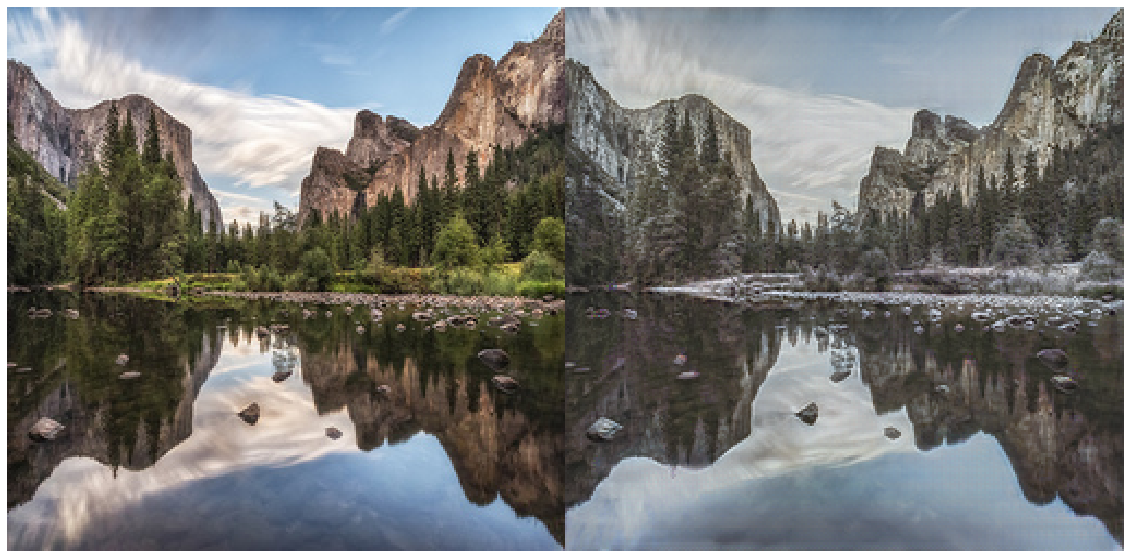

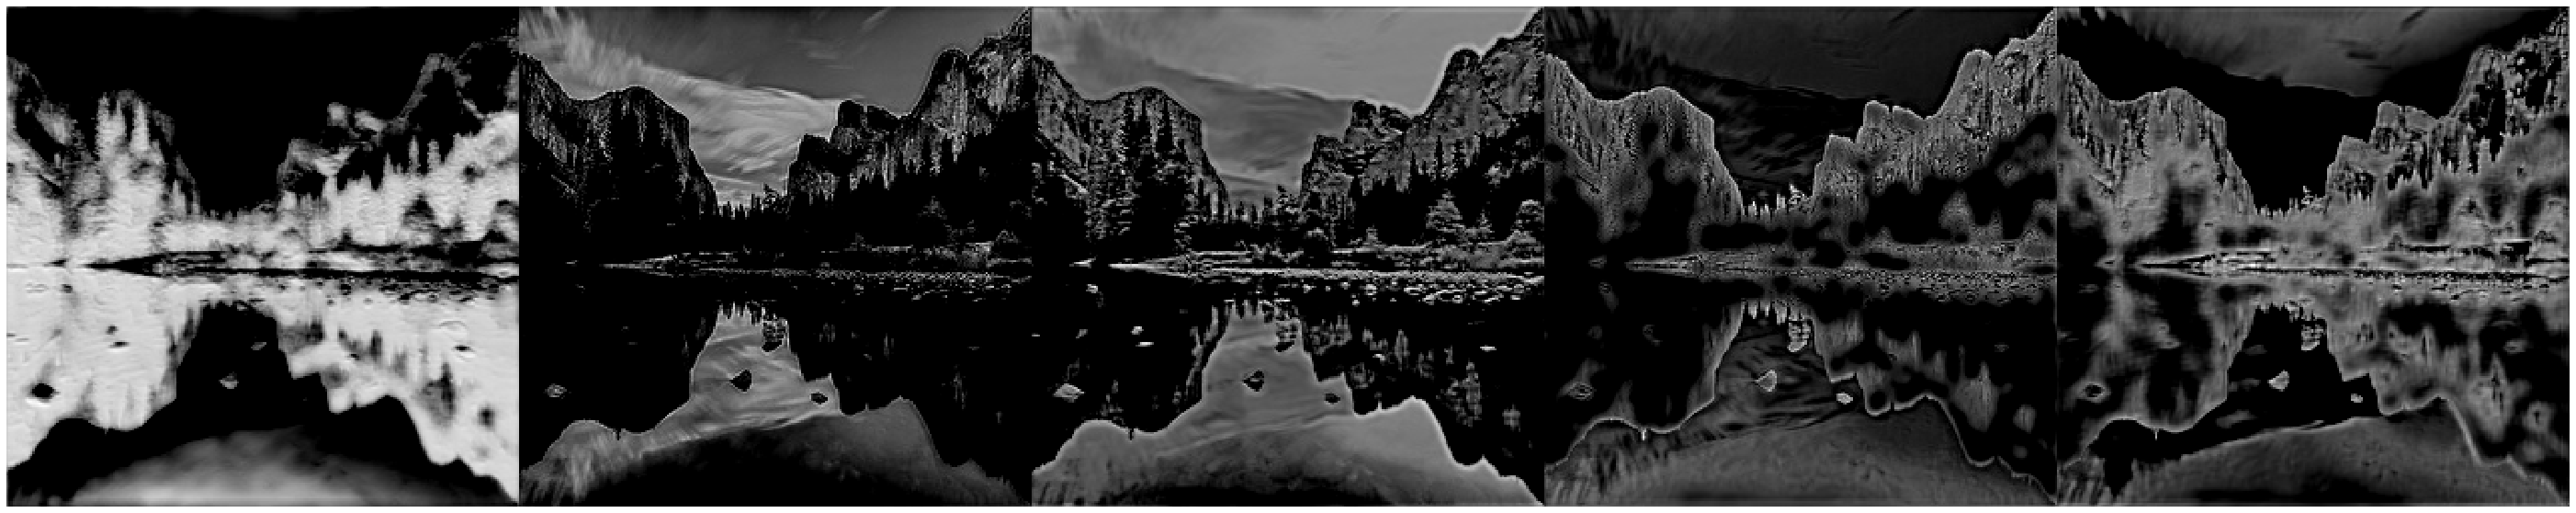

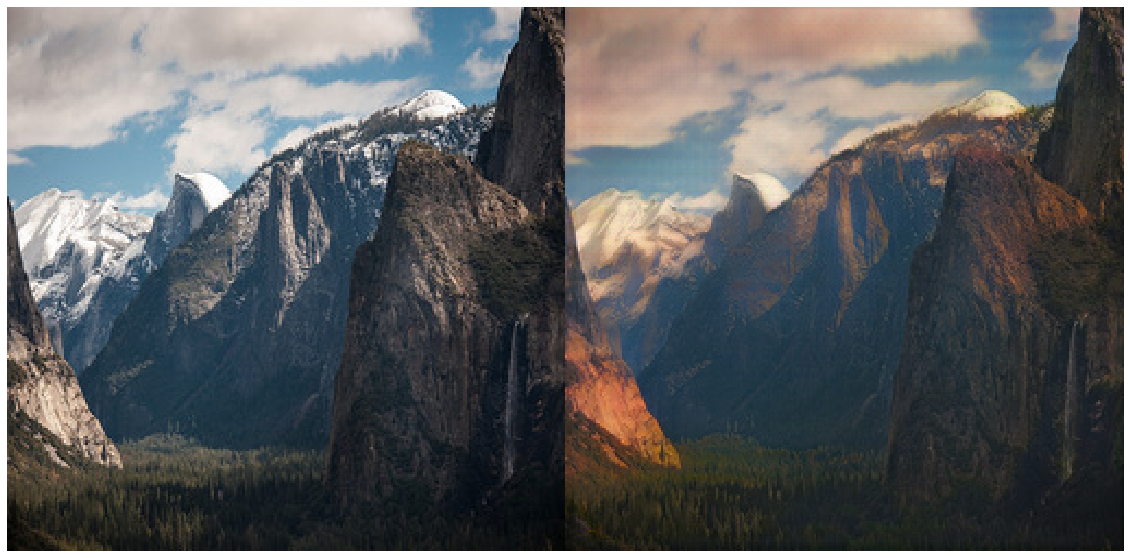

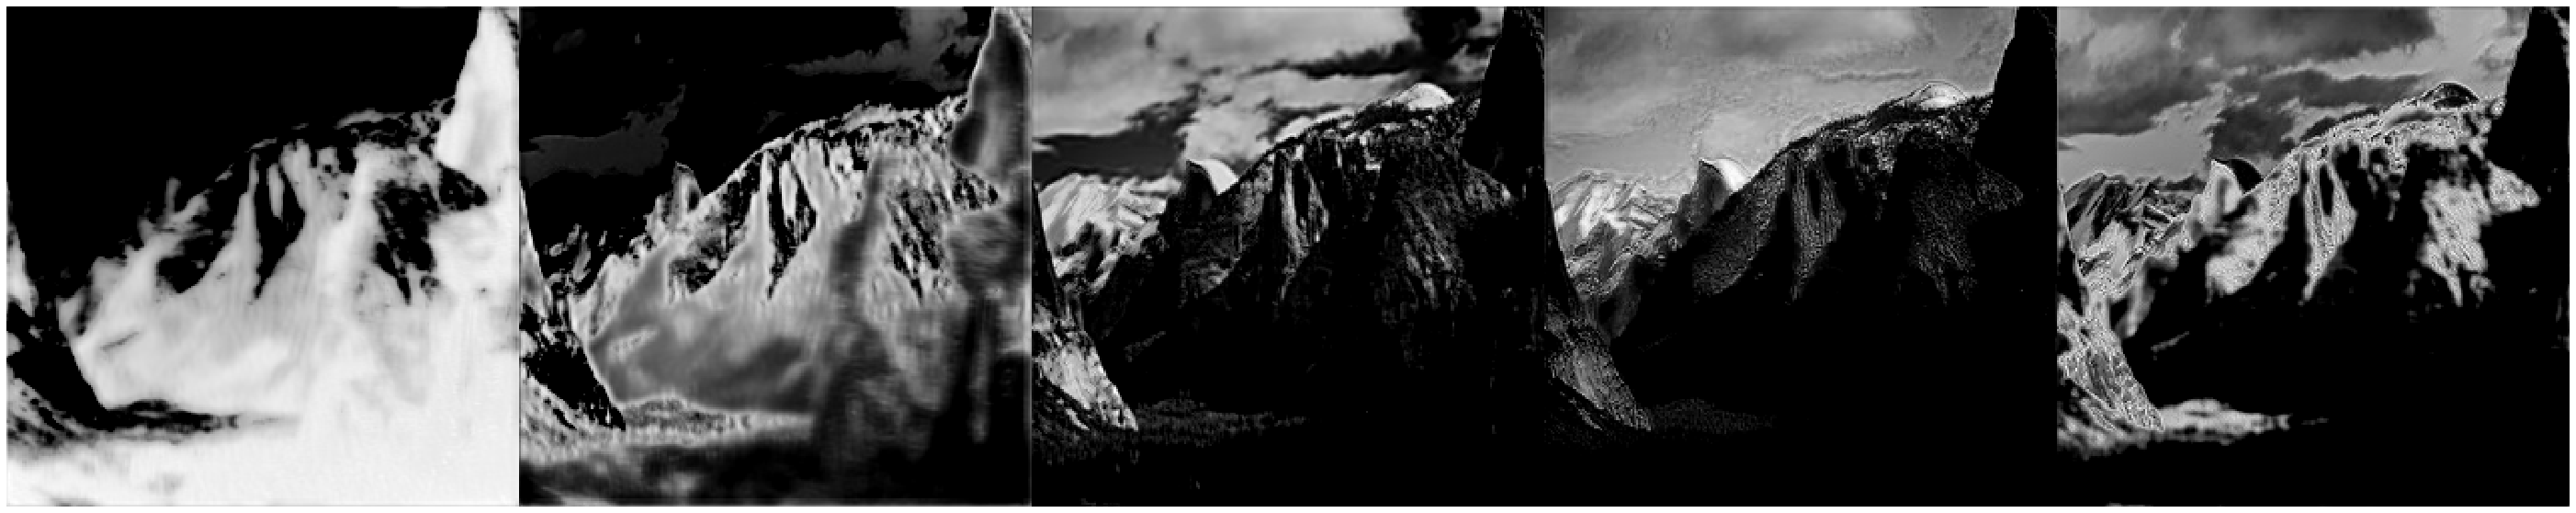

In [12]:
netG_A2B.eval()
netG_B2A.eval()
temp_batch = next(temp_batch_iter)

with torch.no_grad():
    
    imgA = temp_batch[0].to(device)
    imgB = temp_batch[1].to(device)

    fakeA, _, attB = netG_B2A(imgB)
    fakeB, _, attA = netG_A2B(imgA)

    dataloader.show_example([imgA, fakeB.detach()], (20, 10)) 
    dataloader.show_example(attA, (50, 10))
    dataloader.show_example([imgB, fakeA.detach()], (20, 10)) 
    dataloader.show_example(attB, (50, 10))        

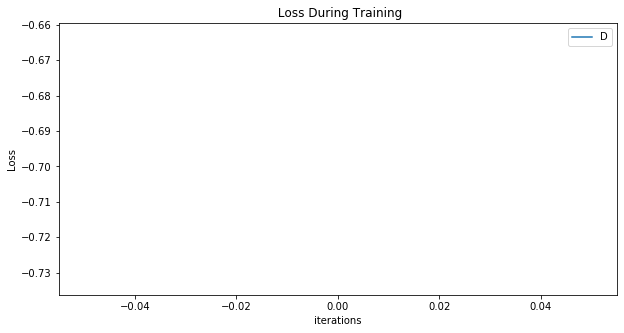

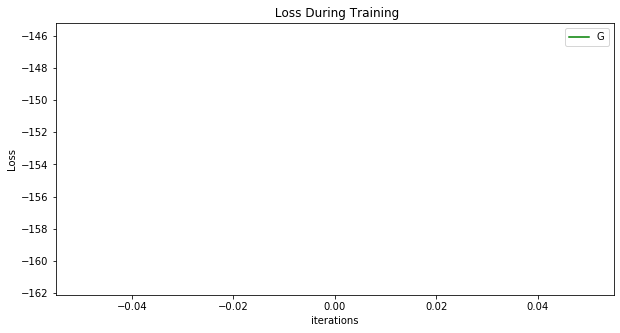

In [11]:
plt.figure(figsize=(10,5))
plt.title(" Loss During Training")
plt.plot(loss_list_D,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title(" Loss During Training")
plt.plot(loss_list_G,label="G", color='green')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 4.2 Save colorization results

Save colorization results on val/test batch on `./outputs/sketch2color` directory.

The saved images have form of **Reference/Edge/Colorization Result/Ground Truth**

In [10]:
# validation funciton
def save_images(data_loader, model):
    with torch.no_grad():
        # Prepare value counters and timers
        for i, data in enumerate(data_loader, 0):
            # Record time to do forward passes and save images
            start = time.time()
            
            edge = data[0].to(device)
            edge = torch.cat([edge]*6, dim=0)
            real = data[1].to(device)
            real = torch.cat([real]*6, dim=0)
            reference = refer_batch[1].to(device)
            color_palette = refer_batch[2]
            input_tensor = torch.cat([edge.cpu()]+color_palette, dim=1).to(device)
            fake = netG(input_tensor)
            result = torch.cat((reference, edge, fake, real), dim=-1)
            output = vutils.make_grid(result, nrow=1, padding=5, normalize=True).cpu().permute(1,2,0).numpy()
            
            # Save images to file
            save_path = 'outputs/sketch2color/'
            save_name = 'img-{}.jpg'.format(i)
            plt.imsave(arr=output, fname='{}{}'.format(save_path, save_name))

            # Record time to do forward passes and save images
            end = time.time()

            # Print model accuracy -- in the code below, val refers to both value and validation
            print('\rSave: [{0}/{1}]\t'
                'Time {2:0.3f}s \t'
                .format(i+1, len(data_loader), end - start), end='')

In [11]:
with torch.no_grad():
    netG.eval()
    save_images(test_loader, netG)

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 6 and 1 in dimension 0 at C:\w\1\s\tmp_conda_3.7_183424\conda\conda-bld\pytorch_1570818936694\work\aten\src\TH/generic/THTensor.cpp:689